## HW 5 - Page Rank - EXTRA CREDIT
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2025`__

> Updated: 11/24/2025

This is also a Team Homework, using the same team as the Final Project. **What's the catch? There are 4 questions, each student in the team has to author at least one question. Question 4 is the hardest, so for teams of 5 or more, this question can be shared**

**Clone this notebook to be able to run it!**


In Weeks 9 and 10 you discussed key concepts related to graph based algorithms and implemented SSSP. In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia. This homework it's a team homework, thus every team will only submit one notebook. 

By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
pip install graphframes networkx

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# RUN CELL AS IS - Imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# RUN CELL AS IS - Spark Context
sc = spark.sparkContext
spark

### Data Check

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
DATA_PATH = "dbfs:/mnt/mids-w261/HW5/HW5/"
display(dbutils.fs.ls(DATA_PATH))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687,1740500849000
dbfs:/mnt/mids-w261/HW5/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616,1740500849000
dbfs:/mnt/mids-w261/HW5/HW5/indices.txt,indices.txt,517438296,1740500849000
dbfs:/mnt/mids-w261/HW5/HW5/test_graph.txt,test_graph.txt,167,1740500849000


# Question 1: Graph Processing Theory

# Author: Anabel + Carlos 

## a. Distribute Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading. 

### Q1.a Tasks:
* __a) Multiple Choice:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Don't think in terms of any specific algorithm. Think in terms of the nature of the graph data structure itself).*

## b. Representing Graphs
In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of \\(n{_1}\\), \\(n{_2}\\), etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q1.b Tasks:

* __a) Fill in the blanks:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph. 
* __b) Fill in the blanks:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.
* __c) Code:__ Fill in the missing code to complete the function `get_adj_matr()`.
* __d) Code:__ Fill in the missing code to complete the function `get_adj_list()`.
* __e) Multiple Choice:__ Which is the correct edge list for node `B`?

### Q1.a Student Answers:
> __a)__ Highlight the correct answer (Add ** before and after your selected choice):
* ** It can be hard to represent graphs as distinct records that can be processed separately from each other. **
* Graphs contain nodes and edges, which cannot easily be converted into key-value pairs.
* You need to store the entire graph in memory, so we can only work with small datasets.

### Q1.b Student Answers
> __a)__ Fill in the blanks with any of these possible statements based on the following category.
  > * type = [sparse, dense]
  > * number = [N^2 edges or 5^2 = 25, N(N-1) edges or 5*4 = 20]
  > * efficiency = [more efficient, less efficient]

* This is a relatively **sparse** matrix. If self loops are allowed, then we could have a total of **N² edges or 5² = 25** edges. Otherwise, if self loops are not allowed, we could have **N(N−1) edges or 5×4 = 20** edges. Out of a total possible edges, this graph only has 9 edges. For sparse graphs, their adjacency list representation will be **more efficiency** than their adjacency matrix (memory wise). 


> __b)__ Fill in the blanks with any of these possible statements based on the following category.
  > * graph_type = [directed, undirected]
  > * symmetric = [asymmetric, symmetric]

* This is a **directed** graph. Because we see the edge ('A', 'B') in the graph, but there is no corresponding ('B', 'A'). For directed graphs, the adjacency matrix will be **asymmetric**. Whereas for undirected graphs, it will be **symmetric**. 

> __e)__ Highlight the correct answer (Add ** before and after your selected choice):
* **['C','E']**
* ['D']
* ['A', 'B', 'C']
* ['B', 'D']

In [0]:
# part 1b.a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

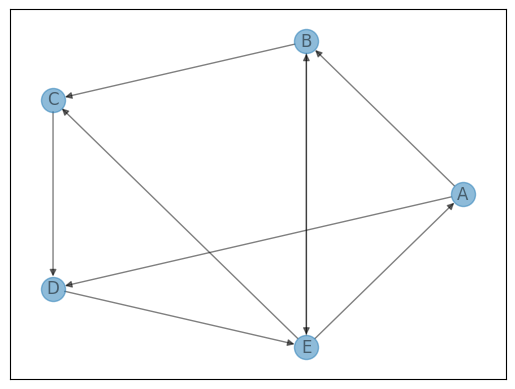

In [0]:
# part 1b.a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw_networkx(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part 1b.c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    # add 1s for each directed edge (src - dst)
    for src, dst in graph['edges']:
        adj_matr.loc[src, dst] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part 1b.c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [0]:
# part 1b.d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for src, dst in graph['edges']:
        adj_list[src].append(dst)
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part 1b.d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 2: Markov Chains, Random Walks and PageRank
# Author: Anabel + Carlos + Arun

## a. Markov Chains and Random Walks
As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

General note: We use a sped-up convergence method for the `power_iteration()` function. You should speed up convergence by multiplying by the tMatrix twice. `tMatrix = tMatrix.dot(tMatrix)`. So instead of:

```
Step 0: xInit * tMatrix
Step 1: xInit * tMatrix^2
Step 2: xInit * tMatrix^3
Step 3: xInit * tMatrix^4
...
```

you should instead consider

```
Step 0: xInit * tMatrix
Step 1: xInit * tMatrix^2
Step 2: xInit * tMatrix^4
Step 3: xInit * tMatrix^8
...
```

This may vary slightly from what you see in Demo 10

### Q2.a Tasks:

* __a) Multiple Choice:__ It is common to explain PageRank using the analogy of a web surfer who visits a page, randomly clicks a link on that page, and repeats ad infinitum. In the context of this hypothetical infinite random walk across web pages on the internet, which of the following choices most clearly describes the event that the __teleportation__ represents?

* __b) Fill in the blanks:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) Fill in the blanks:__ A Markov chain consists of \\(n\\) states plus an \\(n\times n\\) transition probability matrix. In the context of PageRank & a random walk over the WebGraph, what are the \\(n\\) states? what implications does this have about the size of the transition matrix?

* __d) Code + Numerical Answer:__ Fill in the code below to compute the transition matrix for the toy graph from question 1. What is the value in the middle column of the last row (the probability of transitioning from node `E` to `C`)? Include the leading digit in front of the decimal, and round the number to at least 4 decimal places. Examples: 1.0000 or 0.1234. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) Code:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.
    * __`NOTE 3:`__ _refer to the General note section above, and use the `tMatrix = tMatrix.dot(tMatrix)` approach for faster convergence_.

* __f) Numerical Answer:__ How many iterations does it take to converge? Define convergence as the step where you can identify conevergence. Example: If step 4 the value is 0.435 and in step 5 the value is also 0.435, you identified convergence in step 5.

* __g) Multiple Choice:__ Which node is the least 'central' (i.e., it has the lowest ranked)?

## b. Page Rank Theory
Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' from before and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from before on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q2.b Tasks:

* __a) Code + Multiple Choice:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from before. What are the first values in steps 1, 2, and 3 of the power iteration method? [__`HINT:`__ _We start the iteration at step number 0. If you start your iteration at step number 1, then you should answer with the values from step 2, 3, and 4 instead_]

* __b) Multiple Choice:__ What is wrong with what you see in part a? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __c) Multiple Choice:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __d) Multiple Choice:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Choose your reasoning.

* __e) Multiple Choice:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Choose your reasoning.

* __f) Multiple Choices:__ What modifications to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? [__`HINT:`__ _select 2 answers_]


### Q2.a Student Answers:
> __a)__ Highlight the correct answer (Add ** before and after your selected choice):

* Randomly traveling to a linked site from the current page.*
* Deterministically going to a linked site from a the current page.*
* **Randomly traveling to a non-linked site from the current page.**
* A self-loop in which the user clicks a link to return the same page.

> __b)__ Fill in the blanks with any of these possible statements based on the following category.
  > * property = [memorylessness, randomness]
  > * assumption = [the probability of transitioning from one page to another is stable regardless of past browsing history, the probability of transitioning from one page to another changes according to the past browsing history]

* The Markov Property is the property of **memorylessness**. In the context of Page Rank, this is the assumption that **the probability of transitioning from one page to another is stable regardless of past browsing history**.

> __c)__ Fill in the blanks with any of these possible statements based on the following category.
  > * states = [links, webpages]
  > * size = [large, relatively small]

* The n states are the **webpages**. Therefore, the size of the transition matrix will be **large**.

> __d)__ Numeric Answer: 0.3333

> __f)__ Numeric Answer: step 6

> __g)__ Highlight the correct answer (Add ** before and after your selected choice):
* **A**
* B
* C
* D
* E

### Q2.b Student Answers:
> __a)__ Highlight the correct answer (Add ** before and after your selected choice):
* **[0, 0, 0]**
* [0.16666667, 0.02777778, 0.0007716]
* [0.16666667, 0.16666667, 0.16666667]
* [0.16666667, 0, 0.16666667]

> __b)__ Highlight the correct answer (Add ** before and after your selected choice):
* Each column should represent a probability distribution but these don't sum to 1. In fact the more iterations we run, the higher their sum is.
* **Each column should represent a probability distribution but these don't sum to 1. In fact the more iterations we run, the lower their sum is.**


> __c)__ Highlight the correct answer (Add ** before and after your selected choice):
* A dangling node is a node with outlinks but no inlinks. We need to redistribute the dangling mass to maintain stochasticity.
* A dangling node is a node with no outlinks or inlinks. We need to redistribute the dangling mass to maintain stochasticity.
* **A dangling node is a node with inlinks but no outlinks. We need to redistribute the dangling mass to maintain stochasticity.**

> __d)__ Highlight the correct answer (Add ** before and after your selected choice):
* **Irreducibility: There must be a sequence of transitions of non-zero probability from any state to any other. In other words, the graph has to be connected (a path exists from all vertices to all vertices). No, the webgraph is not irreducible as it will have disconnected segments.**
* Irreducibility: There must be a sequence of transitions of non-zero probability from any state to any other. In other words, the graph has to be connected (a path exists from all vertices to all vertices). Yes, the webgraph is irreducible as all segments are connected.

> __e)__ Highlight the correct answer (Add ** before and after your selected choice):
* **Aperiodicity: States are not partitioned into sets such that all state transitions occur cyclicly from one set to another. No, the web graph is not aperiodic as all links are outlinks.**
* Aperiodicity: States are not partitioned into sets such that all state transitions occur cyclicly from one set to another. Yes, the web graph is aperiodic as all we need is a single page with a link back to itself. An anchor link is one such link.

> __f)__ Highlight the correct answers - 2 options (Add ** before and after your selected choice):
* **teleportation**
* oversampling
* **dampening**
* deterministic random surfer behavior

In [0]:
# part 2.a.d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part 2.a.d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.div(TOY_ADJ_MATR.sum(axis=1), axis=0)

################ (END) YOUR CODE #################
print(transition_matrix)

          A         B         C    D    E
A  0.000000  0.500000  0.000000  0.5  0.0
B  0.000000  0.000000  0.500000  0.0  0.5
C  0.000000  0.000000  0.000000  1.0  0.0
D  0.000000  0.000000  0.000000  0.0  1.0
E  0.333333  0.333333  0.333333  0.0  0.0


In [0]:
# part 2.a.e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit

    for i in range(nIter):
        state_vector = state_vector.dot(tMatrix)

        if verbose:
            print(f"Step {i}: {state_vector}")

        # accelerated convergence: square transition matrix each step
        tMatrix = tMatrix.dot(tMatrix)
    
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part 2.a.e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step 0: [0.  0.5 0.  0.5 0. ]
Step 1: [0.25 0.25 0.25 0.25 0.  ]
Step 2: [0.0625     0.13541667 0.16666667 0.28125    0.35416667]
Step 3: [0.10575408 0.15948511 0.18465873 0.23851032 0.31159176]
Step 4: [0.10526138 0.15789075 0.18420926 0.23683893 0.31579969]
Step 5: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 6: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 7: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 8: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 9: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]


__`Expected Output for part 2.a.e after 10 iterations:`__  
>Steady State Probabilities:
```
[0.10526316 0.15789474 0.18421053 0.23684211 0.31578947] 
```

In [0]:
# part 2.b.a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

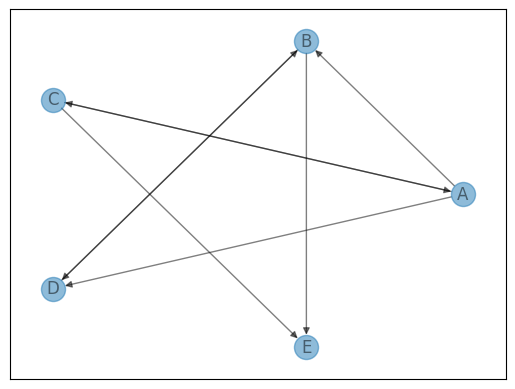

In [0]:
# part 2.b.a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw_networkx(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part 2.b.a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
adj_matr = get_adj_matr(TOY2_GRAPH)
row_sums = adj_matr.sum(axis=1)

# keep dangling rows as all-zero (no NaNs)
trans_matr = adj_matr.div(row_sums.replace(0, 1), axis=0)

xInit = np.array([1.0, 0, 0, 0, 0])
state = power_iteration(xInit, trans_matr, 10, verbose=True)

################ (END) YOUR CODE #################


Step 0: [0.         0.33333333 0.33333333 0.33333333 0.        ]
Step 1: [0.         0.22222222 0.05555556 0.22222222 0.16666667]
Step 2: [0.         0.0617284  0.00154321 0.0617284  0.06018519]
Step 3: [0.00000000e+00 3.90565463e-03 1.19074836e-06 3.90565463e-03
 3.90446388e-03]
Step 4: [0.00000000e+00 1.52587887e-05 7.08940830e-13 1.52587887e-05
 1.52587880e-05]
Step 5: [0.00000000e+00 2.32830644e-10 2.51298550e-25 2.32830644e-10
 2.32830644e-10]
Step 6: [0.00000000e+00 5.42101086e-20 3.15754807e-50 5.42101086e-20
 5.42101086e-20]
Step 7: [0.00000000e+000 2.93873588e-039 4.98505491e-100 2.93873588e-039
 2.93873588e-039]
Step 8: [0.00000000e+000 8.63616856e-078 1.24253862e-199 8.63616856e-078
 8.63616856e-078]
Step 9: [0.00000000e+000 7.45834073e-155 0.00000000e+000 7.45834073e-155
 7.45834073e-155]


# Question 3: Data and EDA
# Author: Anabel + Arun + Carlos

## About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation (note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

## a. EDA - Number of nodes:
As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q3a. Tasks:
* __a) Fill in the blanks:__ What is the format of the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]
* __b) Multiple Choice:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.
* __c) Code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 
* __d) Numerical Answer:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

## b. EDA - Out-Degree distribution:
As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q3b. Tasks:
* __a) Code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
  * Count the number of out-degree for each __non-dangling node__ and return the names of the top 10 pages with the most hyperlinks
  * Find the average out-degree for all __non-dangling nodes__ in the graph
  * Take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
* __b) Numerical Answer:__ What is the average out-degree of the `testRDD`?
* __c) Multiple Choice:__ What is the top node by out-degree of the `wikiRDD`?
* __d) Fill in the blanks:__ In the context of the PageRank algorithm, how is information about a node's out degree used?
* __e) Multiple Choices:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others? Select all that apply. [__Hint:__ _select 3 answers_]

__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}


In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

### Q3.a Student Answers:
> __a)__ Fill in the blanks with any of these possible statements based on the following category.
  > * type = **an adjacency list**
  > * value = **node id**
  > * part = [a tuple of out-edges, a dictionary of linked pages (neighbor nodes) and the number of times that page is linked]
* The raw data is in the format of **an adjacency list**.
* The first value of each line represents **node id**.
* The second part of each line represents **a dictionary of linked pages (neighbor nodes) and the number of times that page is linked**.

> __b)__ Highlight the correct answer (Add ** before and after your selected choice):
* Webpages (i.e. nodes) that are not referenced by a hyperlink (i.e. in-edges) won't have a record in this raw representation of the graph.
* **Webpages (i.e. nodes) that don't have any hyperlinks (i.e. out-edges) won't have a record in this raw representation of the graph.**

> __d)__ Numeric Answer: 9410986

### Q3.b Student Answers:
> __b)__ Numeric Answer: 1.7

> __c)__ Highlight the correct answer (Add ** before and after your selected choice):

* '7858931'
* '**7804599**'
* '7705822'
* '11185362'
* '5760310'

> __d)__ Fill in the blanks with any of these possible statements based on the following category.
  > * value = [probability of random jump, total inbound links, current rank (or current mass)]
  > * node = [each of its neighbor(s), every node in the network]

  * The outdegree is used in calculating each node's "contribution" to its neighbors upon each iteration/update step. Specifically we take a node's **current rank (or current mass**, divide it by the out-degree, and then redistribute that value to **each of its neighbor(s)** to get added up.

> __e)__ Highlight the correct answers (Add ** before and after your selected choice):

* **Nodes with out-degree 0 are dangling nodes (also known as 'sinks').**
* A node with out-degree 0 has a full adjacency list which contains all other nodes in the network.
* **Without modification of distribution, the mass from the nodes with out-degree 0 is not distributed to other nodes. The total rank (or accumulated mass) from all nodes will be less than 1, and using Markov chain will not converge.**
* Without modification of distribution, the mass from the nodes with out-degree 0 is randomly distributed to other nodes using teleport vector.
* **In PageRank, we redistribute the mass from nodes with out-degree 0 evenly across the rest of the graph in PageRank.**

In [0]:
# part 3.a.b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290 - Approx. time: 20.55 seconds
print(wikiRDD.count())

5781290


In [0]:
# part 3.a.c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    parsed = dataRDD.map(lambda x: x.split('\t')) \
                    .map(lambda x: (int(x[0]), ast.literal_eval(x[1])))

    # source nodes
    sources = parsed.map(lambda x: x[0])

    # destination nodes
    dests = parsed.flatMap(lambda x: x[1].keys()).map(int)

    # total unique nodes
    totalCount = sources.union(dests).distinct().count()
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part 3.a.c - run your counting job on the test file (RUN THIS CELL AS IS)
# Approx time: 0.41 seconds
tot = count_nodes(testRDD)
print(f'Total Nodes: {tot}')

Total Nodes: 11


In [0]:
# part 3.a.c - run your counting job on the full file (RUN THIS CELL AS IS)
# Approx time: 6.35 minutes
tot = count_nodes(wikiRDD)
print(f'Total Nodes: {tot}')

Total Nodes: 15192277


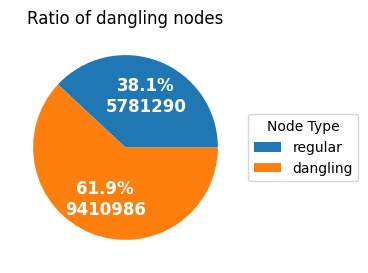

In [0]:
# part 3.a.d - number of dangling nodes - Use your previous results! You can hard code the number using arithmetic of previous results
############## YOUR CODE HERE ###############
num_dangling = 15192277 - 5781290
############## (END) YOUR CODE ###############   

# RUN AS IS
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

data = [5781290, num_dangling]
labels = ["regular", "dangling"]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, labels,
          title="Node Type",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Ratio of dangling nodes")
display(plt.show())

In [0]:
# part 3.b.a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out
    
    
    -degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    # parse (node, edges_dict)
    parsed = dataRDD.map(parse)

    # out-degree = total hyperlinks (sum of edge multiplicities in dict)
    # keep only non-dangling nodes (out-degree > 0)
    outdeg = parsed.mapValues(lambda d: sum(d.values())).filter(lambda x: x[1] > 0)

    #  top 10 pages by out-degree 
    top = outdeg.takeOrdered(10, key=lambda x: -x[1])

    # average out-degree over non-dangling nodes 
    sum_deg, cnt = outdeg.map(lambda x: (x[1], 1)).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    avgDegree = sum_deg / cnt

    # sample n out-degree values (integers) 
    sampledCounts = outdeg.values().takeSample(False, n, seed=42)

    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part 3.b.b - run your job on the test file (RUN THIS CELL AS IS)
# Approx time: 1.20 seconds
test_results = count_degree(testRDD,10)
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

Average out-degree:  2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]


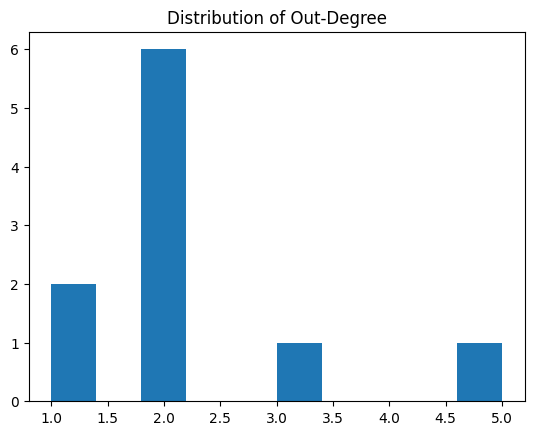

In [0]:
# part 3.b.b - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part 3.b.c - run your job on the full file (RUN THIS CELL AS IS)
# Approx time: 3.69 minutes
full_results = count_degree(wikiRDD,1000)
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

Average out-degree:  32.04181575392343
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]


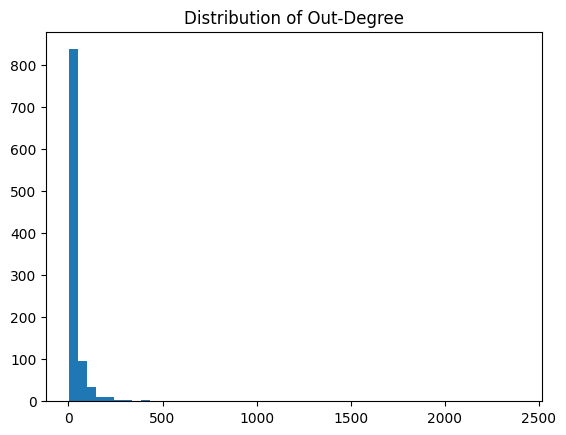

In [0]:
# part 3.b.c - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
top10, avgDeg, sample = count_degree(wikiRDD, 1000)
top10[:5]


[('7883280', 7132),
 ('7884831', 5877),
 ('6075450', 5875),
 ('6074992', 5855),
 ('7828359', 5839)]

# Question 4: PageRank
# Author: Anabel + Nicole + Shikah

## a. Initialize the Graph
One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q4.a Tasks:
* __a) Multiple Choice:__ What is \\(N\\)? 

* __b) Multiple Choices:__ Using the analogy of the infinite random web-surfer, how do we use \\(\frac{1}{N}\\)? [__HINT:__ _select 2 answers_]

* __c) Code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it edges (neighbors) to be a empty [__HINT:__ _you should use the same data type with the edges for non-dangling nodes_]
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring

* __d) Numerical Answer:__ Run the provided code to confirm that your job in `part c` has a record for each node. Your records should match the format specified in the docstring and the count should match what you computed in question 3a. Then answer the question: how many edges does the node `13415942` have? [__`TIP:`__ _you might want to take a moment to write out what expected outputs you should get for the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.


## b. Iterate until Convergence
Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>

__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The \\(P\\) on the left hand side of the equation is the new score, and the \\(P\\) on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, \\(|G|\\) is the number of nodes in the graph (which we've elsewhere refered to as \\(N\\)).

### Q4.b Tasks:
* __a) Multiple Choices:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: \\(\alpha * \frac{1}{|G|}\\). 
    [__Hint__: _select two answers_]

* __b) Multiple Choice:__ In the equation for the PageRank calculation above what does \\(m\\) represent and why do we divide it by \\(|G|\\)?

* __c) Numerical Answer:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) Code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.

* __e) Multiple Choice:__  What is the top ranked node of the `wikiaGraphRDD`?
    
> TIP: You can check your work for part `d` by looking at the nodes in the top 20-40th positions by PageRank score, which should match the expected output.

__WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

__NOTE:__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q4.a Student Answers:
> __a)__ Highlight the correct answer (Add ** before and after your selected choice):
* The rank for each edge
* The total number of edges in the graph
* The rank for each node
* **The total number of nodes in the graph**
* The total number of non-dangling nodes in the graph

> __b)__ Highlight the correct answers (Add ** before and after your selected choice):

* **To initialize each node's rank**
* To identify where each node should converge to
* To suggest that the random surfer is equally likely to end her random walk anywhere on the graph
* **To suggest that the random surfer is equally likely to start her random walk anywhere on the graph**

> __d)__ Numeric Answer: 13415942

### Q4.b Student Answers:
> __a)__ Highlight the correct answers (Add ** before and after your selected choice):

* **alpha is the number of nodes, with an equal probability of being "jumped to".**
* **\\(|G|\\) is the number of nodes, with an equal probability of being "jumped to"**.
* alpha is the teleportation factor (i.e. the probability of a random jump)
* \\(|G|\\)  is the teleportation factor (i.e. the probability of a random jump)

> __b)__ Highlight the correct answer (Add ** before and after your selected choice):

* m is the total mass of all nodes which we distribute to all |G| nodes equally.
* **m is the dangling mass which we distribute to all |G| nodes equally.**

> __c)__ Numeric Answer: 1.0

> __e)__ Highlight the correct answer (Add ** before and after your selected choice):

* 1184351
* **13455888**
* 4695850
* 5051368
* 2437837

In [0]:
# part 4.a.c - job to initialize the graph
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############
    import ast

    # Parse raw line -> (src_node:int, edges_dict:{dst(str): count(int)})
    def parse(line):
        node, edges = line.split('\t')
        return (int(node), ast.literal_eval(edges))

    parsed = dataRDD.map(parse).cache()

    # Source nodes
    sources = parsed.keys().distinct()

    # Destination nodes (DON'T split strings; use dict keys directly)
    dests = parsed.flatMap(lambda kv: [int(dst) for dst in kv[1].keys()]).distinct()

    # All nodes
    all_nodes = sources.union(dests).distinct().cache()

    # N (do not hardcode)
    N = all_nodes.count()
    init_score = 1.0 / N

    # Convert edges_dict -> outlinks_str with repeats (preserve multi-links)
    def to_outlinks_str(edges):
        out = []
        for dst, c in edges.items():
            out.extend([str(dst)] * int(c))   # repeat by count
        return ",".join(out)

    # Non-dangling nodes: (node, (score, outlinks_str))
    graph_non_dangling = parsed.mapValues(lambda edges: (init_score, to_outlinks_str(edges)))

    # Dangling nodes: (node, (score, ""))  (empty string = no outlinks)
    dangling_nodes = all_nodes.subtract(sources)
    graph_dangling = dangling_nodes.map(lambda node: (node, (init_score, "")))

    # Final graph
    graphRDD = graph_non_dangling.union(graph_dangling)

    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [0]:
# part 4.a.d - run your Spark job on the test graph (RUN THIS CELL AS IS)
# Approx time: 1.55 seconds
testGraph = initGraph(testRDD).collect()
testGraph

[(2, (0.09090909090909091, '3')),
 (3, (0.09090909090909091, '2,2')),
 (4, (0.09090909090909091, '1,2')),
 (5, (0.09090909090909091, '4,4,4,2,6')),
 (6, (0.09090909090909091, '2,5,5')),
 (7, (0.09090909090909091, '2,5')),
 (8, (0.09090909090909091, '2,5')),
 (9, (0.09090909090909091, '2,5')),
 (10, (0.09090909090909091, '5')),
 (11, (0.09090909090909091, '5,5')),
 (1, (0.09090909090909091, ''))]

In [0]:
# part 4.a.d - run your code on the main graph (RUN THIS CELL AS IS)
# Approx time: 8.16 minutes
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 56.420079946517944 seconds


In [0]:
# part 4.a.d - confirm record format and count (RUN THIS CELL AS IS)
# Approx time: 2.40 minutes
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
node = wikiGraphRDD.sortByKey().lookup(13415942) 
print("Node 13415942's initialized record:", node)
print(f"\n\nNode 13415942 has {len(node[0][1].split(','))} outlinks.")
print(f'Time to complete: {time.time() - start} seconds.')

Total number of records: 15192277
Node 13415942's initialized record: [(6.582291778908455e-08, '3504656,9775848,11373963,13852436,3379424,2091222,6677493,6677493,1058085,1053553,1053553,6857069,9003031,5537932,8969422,13432623,8886615,3144451,2716670,13915988,1477521,5685569,9378589,5833323,13812056,13443607,6369178,9308815,13838758,9363771,8481855,4962740,9391535,13506560,11933440,8048021,14003665,2091220,2091220,3094953,3094953,3094953,6167868,10232538,4962727,12254674,6085187,13853352,4763720,2396377,10918156,2722192,10131325,9704310,11544220,495535,9268175,3170806,3170806,9003037,9003037,3969908,14007066,13455888,14703794,14024536,1644036,5268185,11620493,12061491,12061491,9255564,6312586,3103819,1053549,6514419,4382835,13328060,2958561,9373697,3042177,14730511,7634942,2368552,14743233,4047561,12690702,7491066,8129926,13834510,13834510,984402,984402,12962553,12061480,3814267,6957969,5770648,5770648,13432242,13432242,6702970,11859764,10737734,10737734,8251474,1346778,13444906,868685

In [0]:
# part 4.b.d - provided FloatAccumulator class (RUN THIS CELL AS IS)
from pyspark.accumulators import AccumulatorParam
class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part 4.b.d - job to run PageRank
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
  
    ############## YOUR CODE HERE ###############
def runPageRank(graphInitRDD, alpha=0.15, maxIter=10, verbose=True):
    a = sc.broadcast(alpha)
    d = sc.broadcast(1 - a.value)

    # N should be computed once
    N = graphInitRDD.count()
    Nb = sc.broadcast(N)

    # persist base graph structure (edges)
    edgesRDD = graphInitRDD.mapValues(lambda x: x[1]).persist()

    # ranks only
    ranksRDD = graphInitRDD.mapValues(lambda x: x[0]).persist()

    def is_dangling(outlinks):
        return outlinks is None or outlinks == ""

    def contribs(node_rank_outlinks):
        node, (rank, outlinks) = node_rank_outlinks
        if is_dangling(outlinks):
            return []
        outs = [x for x in outlinks.split(",") if x != ""]
        L = len(outs)
        if L == 0:
            return []
        share = rank / L
        return [(int(dst), share) for dst in outs]

    for i in range(maxIter):
         # (node, (rank, outlinks))
        joined = ranksRDD.join(edgesRDD) 

        # dangling mass (one action per iter)
        dangling_mass = joined.filter(lambda kv: is_dangling(kv[1][1])) \
                              .map(lambda kv: kv[1][0]).sum()

        dangling_share = dangling_mass / Nb.value

        incoming = joined.flatMap(contribs).reduceByKey(lambda x, y: x + y)

        # ensure all nodes exist
        incoming_full = edgesRDD.keys().map(lambda n: (n, 0.0)) \
                          .union(incoming).reduceByKey(lambda x, y: x + y)

        newRanksRDD = incoming_full.mapValues(
            lambda inc: a.value / Nb.value + d.value * (inc + dangling_share)
        ).persist()

        # materialize + cleanup
        newRanksRDD.count()
        ranksRDD.unpersist()
        ranksRDD = newRanksRDD

        if verbose:
            total_mass = ranksRDD.map(lambda kv: kv[1]).sum()
            print(f"iter {i+1}: total_mass={total_mass:.6f}, dangling_mass={dangling_mass:.6f}")

    return ranksRDD


    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part 4.b.d - run PageRank on the test graph (RUN THIS CELL AS IS)
# Note: while developing your code you may want turn on the verbose option
# Approx time: 11.80 seconds
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 30.930267572402954 seconds.
Top 20 ranked nodes:


[(2, 0.3620640495978872),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (7, 0.01692511778009981),
 (8, 0.01692511778009981),
 (9, 0.01692511778009981),
 (10, 0.01692511778009981),
 (11, 0.01692511778009981)]

---
__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```
---

In [0]:
# part 4.b.d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTES: 
# - wikiGraphRDD should have been computed & cached above!
# - Rounding errors after 10 or so decimal places are acceptable
# - This will take a long time to run...about 1.4 hours with 2 workers.
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'\n...trained {nIter} iterations in {time.time() - start} seconds.\n')

print(f'Top 20-40th ranked nodes:\n')
top_40 = full_results.takeOrdered(40, key=lambda x: - x[1])
# print results from 20th to 40th highest PageRank
for result in top_40[20:]:
    print(result)

iter 1: total_mass=1.000000, dangling_mass=0.619459
iter 2: total_mass=1.000000, dangling_mass=0.496237
iter 3: total_mass=1.000000, dangling_mass=0.458459
iter 4: total_mass=1.000000, dangling_mass=0.445186
iter 5: total_mass=1.000000, dangling_mass=0.440201
iter 6: total_mass=1.000000, dangling_mass=0.438184
iter 7: total_mass=1.000000, dangling_mass=0.437327
iter 8: total_mass=1.000000, dangling_mass=0.436945
iter 9: total_mass=1.000000, dangling_mass=0.436768
iter 10: total_mass=1.000000, dangling_mass=0.436683

...trained 10 iterations in 399.6273739337921 seconds.

Top 20-40th ranked nodes:

(9386580, 0.0002956970419561084)
(15164193, 0.0002843018514561607)
(7576704, 0.0002807028694625854)
(12074312, 0.0002789390949914672)
(3191491, 0.00027331798906115614)
(2797855, 0.00027289549466343553)
(11253108, 0.00027242406044592274)
(13725487, 0.0002702094553761324)
(2155467, 0.00026649298167908975)
(7835160, 0.00026125677808557765)
(4198751, 0.0002589299830748917)
(9276255, 0.00025463386

---
**Expected output for pages in top 20-40:**
```
(9386580, 0.0002956970419566159)
(15164193, 0.0002843018514565407)
(7576704, 0.00028070286946292773)
(12074312, 0.0002789390949918953)
(3191491, 0.0002733179890615315)
(2797855, 0.0002728954946638793)
(11253108, 0.000272424060446348)
(13725487, 0.00027020945537652716)
(2155467, 0.0002664929816794768)
(7835160, 0.00026125677808592145)
(4198751, 0.00025892998307531953)
(9276255, 0.0002546338645363715)
(10469541, 0.0002537014715361682)
(11147327, 0.00025154645090952246)
(5154210, 0.00024927029620654557)
(2396749, 0.0002481158912959703)
(3603527, 0.0002465136725657213)
(3069099, 0.00023478481004084842)
(12430985, 0.0002334928892642041)
(9355455, 0.00022658004696908508)
```
 ---

### Congratulations, you have completed the last homework for 261! 